Company XYZ is an online grocery store. In the current version of the website, they have manually grouped the items into a few categories based on their experience. 

However, they now have a lot of data about user purchase history. Therefore, they would like to put the data into use! This is what they asked you to do: 
* The company founder wants to meet with some of the best customers to go through a focus group with them. You are asked to send the ID of the following customers to the founder: 
    * the customer who bought the most items overall in her lifetime 
    * for each item, the customer who bought that product the most 
* Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [1]:
import re
from collections import Counter
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Index
* [Load the data](#Load-the-data)
* [Build user-item-count matrix](#Build-user-item-count-matrix)
* [Answer question 1](#Answer-question-1)
* [Answer question 2](#Answer-question-2)
* [Build item-item-similarity matrix](#Build-item-item-similarity-matrix)
* [Answer question 3: Clustering](#Clustering)

## Load the data

In [4]:
items = pd.read_csv("item_to_id.csv", index_col='Item_id')
items.sort_index(inplace=True)
items.head()

,Item_name
Item_id,
1,sugar
2,lettuce
3,pet items
4,baby items
5,waffles


In [5]:
purchase_history = pd.read_csv("purchase_history.csv")
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


## Build user-item count matrix

In [6]:
def item_counts_by_user(same_user_df):
    # 'sum' here is adding two lists into one big list
    all_item_ids = same_user_df['id'].str.split(',').sum()
    # transform from string to int, make it easier to be sorted later
    return pd.Series(Counter(int(id) for id in all_item_ids))

In [7]:
user_item_counts = purchase_history.groupby("user_id").apply(item_counts_by_user).unstack(fill_value=0)

In [8]:
user_item_counts.shape

(24885, 48)

In [9]:
# each row in user_item_counts represents one user
# each column in user_item_counts represents one item
# [u,i] holds the number which user 'u' boughts item 'i'
user_item_counts.sample(5)

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
1374529,0,1,2,0,0,0,0,0,0,0,...,0,0,2,1,0,1,2,0,1,0
47718,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1107231,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1497030,3,1,2,0,1,2,0,0,0,1,...,2,1,1,1,1,1,1,2,0,0
814498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Answer question 1

the customer who bought the most items overall in her lifetime

In [12]:
# we assume each "item id" in the purchase history stands for 'item_count=1'
user_item_total = user_item_counts.sum(axis=1)
print( "custom who bought most in lifetime is: {}, and he/she bought {} items".format(user_item_total.idxmax(),user_item_total.max()))

custom who bought most in lifetime is: 269335, and he/she bought 72 items


## Answer question 2
for each item, the customer who bought that product the most

In [13]:
max_user_byitem = user_item_counts.apply(lambda s: pd.Series([s.argmax(), s.max()], index=["max_user", "max_count"]))
max_user_byitem = max_user_byitem.transpose()
max_user_byitem.index.name = "Item_id"

C:\Users\Vin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [14]:
# join with item name
max_user_byitem = max_user_byitem.join(items).loc[:, ["Item_name", "max_user", "max_count"]]
max_user_byitem.head()

,Item_name,max_user,max_count
Item_id,,,
1,sugar,31625,4
2,lettuce,31625,5
3,pet items,154960,4
4,baby items,5289,3
5,waffles,217277,3


## Build item-item similarity matrix

In [15]:
# A is |U|*|I|, and each item is normalized
A = normalize(user_item_counts.values, axis=0)
item_item_similarity = A.T.dot(A)
item_item_similarity = pd.DataFrame(item_item_similarity,
                                    index=user_item_counts.columns,
                                    columns=user_item_counts.columns)

In [16]:
item_item_similarity.head() # get a feeling about the data

Item_id,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
Item_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


## Clustering

In [18]:
pca = PCA()
# rotate by PCA, making it easier to be visualized later
items_rotated = pca.fit_transform(item_item_similarity)
items_rotated = pd.DataFrame(items_rotated,
                             index=user_item_counts.columns,
                             columns=["pc{}".format(index+1) for index in range(items.shape[0])])

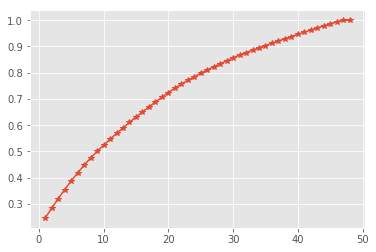

In [19]:
# show the total variance which can be explained by first K principle components
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")

In [22]:
def show_clusters(items_rotated,labels):
    """
    plot and print clustering result
    """
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)

        print ("*********** Label [{}] ***********".format(label))
        names = items.loc[ grp.index,"Item_name"]
        for index, name in enumerate(names):
            print ("\t<{}> {}".format(index+1,name))

    # annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid,"pc1"]
        y = items_rotated.loc[itemid,"pc2"]
        name = items.loc[itemid,"Item_name"]
        name = re.sub('\W', ' ', name)
        plt.text(x,y,name)

    # plt.legend(loc="best")

In [24]:
def cluster(n_clusters,n_components=48):
    """
    n_components=K, means use first K principle components in the clustering
    n_clusters: the number of clusters we want to cluster
    """
    print( "first {} PC explain {:.1f}% variances".format(n_components,
                                                         100 * sum(pca.explained_variance_ratio_[:n_components])))

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(items_rotated.values[:, :n_components])

    # display results
    show_clusters(items_rotated, kmeans.labels_)

In [25]:
# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))

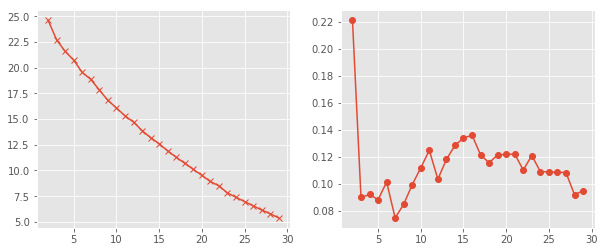

In [26]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(ks,inertias,marker='x')# want to use elbow method to find best k

fig.add_subplot(1,2,2)
plt.plot(ks,silhouettes,marker='o')# the higher the better

based on above plots, ** either elbow method nor silhouette_score can give better hint about the number of clusters **. I decide to try multiple K, and choose the best one according to common sense.

first 48 PC explain 100.0% variances
*********** Label [0] ***********
	<1> grapefruit
	<2> cherries
	<3> apples
	<4> berries
	<5> bananas
*********** Label [1] ***********
	<1> flour
*********** Label [2] ***********
	<1> sandwich bags
	<2> aluminum foil
	<3> paper towels
	<4> toilet paper
*********** Label [3] ***********
	<1> butter
	<2> eggs
	<3> milk
	<4> cheeses
	<5> yogurt
*********** Label [4] ***********
	<1> sugar
	<2> pet items
*********** Label [5] ***********
	<1> shampoo
	<2> shaving cream
	<3> hand soap
	<4> soap
*********** Label [6] ***********
	<1> spaghetti sauce
	<2> canned vegetables
	<3> ketchup
*********** Label [7] ***********
	<1> soda
	<2> tea
	<3> juice
	<4> coffee
*********** Label [8] ***********
	<1> bagels
	<2> tortillas
	<3> dinner rolls
	<4> sandwich loaves
*********** Label [9] ***********
	<1> laundry detergent
	<2> dishwashing 
*********** Label [10] ***********
	<1> lettuce
	<2> carrots
	<3> cucumbers
	<4> broccoli
	<5> cauliflower
*********** Label

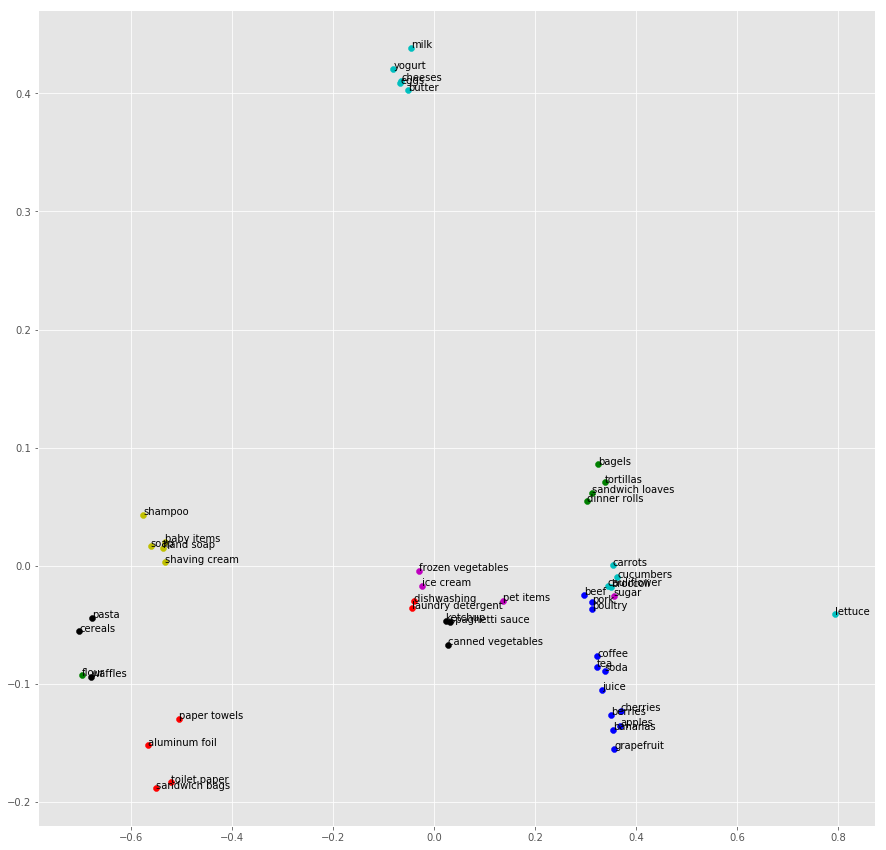

In [27]:
# use all the components
cluster(n_clusters=15)